In [197]:
import numpy as np
import matplotlib.pyplot as plt

In [198]:
T = 2 * np.pi
n = 1000
h = T / n

Q = np.array([[10, 0, 0],[0, 10, 0],[0, 0, 1]])
R = np.array([[1, 0],[0, 1]])
P_1 = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0.1]])

# Goal Trajectory
x_g = np.zeros((n,3))
for i in range(n):
    x_g[i,0] = 2*h*i/np.pi
    x_g[i,2] = np.pi/2

In [199]:
# Dynamics
def dynamics(x0, u):
    x = np.zeros((n,3))
    x[0] = x0
    for i in range(n-1):
        x[i+1,2] = x[i,2] + h*u[i,1]
        x[i+1,0] = x[i,0] + h*np.cos(x[i,2])*u[i,0]
        x[i+1,1] = x[i,1] + h*np.sin(x[i,2])*u[i,0]
    return x

In [200]:
# Cost Function
def J(x, u):
    intg = 0
    for i in range(n):
        intg += h*(np.dot(np.dot((x[i] - x_g[i]).T, Q), (x[i]-x_g[i])) + np.dot(np.dot(u[i].T, R), u[i]))
    final_cost = np.dot(np.dot((x[-1] - x_g[-1]).T, P_1), (x[-1]-x_g[-1]))
    return intg + final_cost

# Cost Function Directional Derivative
def DJ(x, u, zeta):
    intg = 0
    for i in range(n):
        intg += h*2*(np.dot(np.dot((x[i] - x_g[i]).T, Q), zeta[i, :3]) + np.dot(np.dot(u[i].T, R), zeta[i, 3:]))
    D_final_cost = 2*np.dot(np.dot((x[-1] - x_g[-1]).T, P_1), zeta[-1, :3])
    return intg + D_final_cost

In [201]:
# Get zeta
def get_zeta(x, u):
    # (a.T, b.T) = D l(x, u) = (2(x-x_g).T Q, 2u.T R) 
    # A(t) = D1 f(x,u)
    # B(t) = D2 f(x,u)
    A = np.zeros((n,3,3)) # Time, Matrix
    B = np.zeros((n,3,2)) # Time, Matrix
    for i in range(n):
        A[i] = [[0, 0, -np.sin(x[i,2])*u[i,0]], [0, 0, np.cos(x[i,2])*u[i,0]], [0, 0, 0]]
        B[i] = [[np.cos(x[i,2]), 0], [np.sin(x[i,2]), 0], [0, 1]] 

    zeta = np.zeros((n,5))
    P = np.zeros((n,3,3)) # Time, Matrix
    r = np.zeros((n,3)) # Time, Vector
    P[n-1] = P_1
    r[n-1] = [0, 0, 0]

    i = n-1
    while i > 0:
        P_dot = -np.dot(P[i], A[i]) - np.dot(A[i].T, P[i]) + np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), np.dot(B[i].T, P[i])) - Q
        r_dot = np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), 2*np.dot(R.T, u[i])) - 2*np.dot(Q, (x[i] - x_g[i])) - np.dot((A[i] - np.dot(np.dot(np.dot(B[i], np.linalg.inv(R)), B[i].T), P[i])).T, r[i])
        P[i-1] = P[i] - h*P_dot
        r[i-1] = r[i] - h*r_dot

        i -= 1
    
    zeta[0, :3] = [0, 0, 0] # -np.dot(np.linalg.inv(P[0]), r[0]) # or z[0] = 0 --> leads to zeta 0 always
    for i in range(n-1):
        zeta[i, 3:] = -np.dot(np.dot(np.dot(np.linalg.inv(R), B[i].T), P[i]), zeta[i, :3]) - np.dot(np.dot(np.linalg.inv(R), B[i].T), r[i]) - np.dot(np.linalg.inv(R), 2*np.dot(R.T, u[i]))
        zeta[i+1, :3] = np.dot(A[i], zeta[i, :3]) + np.dot(B[i], zeta[i, 3:])
    return zeta

In [202]:
# Initial Trajectory
x0 = [0,0,np.pi/2]
u_init = np.zeros((n,2))
for i in range(n-1):
    u_init[i] = [1, -0.5]
x_init = dynamics(x0, u_init)

# Initial Cost
#J_init = J(x_init, u_init)
#print(J_init)

In [203]:
# iLQR
eps = 0.05 # Threshold

u_iLQR = u_init
x_iLQR = x_init

zeta = np.zeros((n,5)) # zeta = [z0, z1, z2, v0, v1]

i = 0
while i==0 or np.abs(DJ(x_iLQR, u_iLQR, zeta)) > eps:
    # zeta = argmin(DJ(u)*zeta) + 0.5*np.dot(zeta.T, zeta)
    zeta = get_zeta(x_iLQR, u_iLQR)
    print(zeta)
    
    # Armijo
    alpha = 0.5
    beta = 0.1
    gamma = 1
    J_u = J(x_iLQR, u_iLQR)
    DJ_u_zeta = DJ(x_iLQR, u_iLQR, zeta)
    while J(dynamics(x0, u_iLQR + gamma*zeta[:, 3:]), u_iLQR + gamma*zeta[:, 3:]) > J_u + alpha*gamma*DJ_u_zeta:
        gamma *= beta

    # Update u, x for all times
    for j in range(n):
        u_iLQR[j] += gamma*zeta[j, 3:]
    x_iLQR = dynamics(x0, u_iLQR)
    i += 1


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.61114381e+00
  -3.60023985e+00]
 [-1.59886446e-16 -2.61114381e+00 -3.60023985e+00  6.98566598e+00
   6.80440573e+00]
 [ 3.62216816e+00  6.97432104e+00  6.80440573e+00 -2.58191082e+01
  -1.31146059e+01]
 ...
 [            nan             nan             nan             nan
              nan]
 [            nan             nan             nan             nan
              nan]
 [            nan             nan             nan  0.00000000e+00
   0.00000000e+00]]


/var/folders/rq/0rdc24wj25v1w8c48_g0srzm0000gn/T/ipykernel_27086/3410845771.py:13: RuntimeWarning: invalid value encountered in scalar add
  intg += h*2*(np.dot(np.dot((x[i] - x_g[i]).T, Q), zeta[i, :3]) + np.dot(np.dot(u[i].T, R), zeta[i, 3:]))


Text(0.5, 0.98, 'Optimized Controls')

Error in callback <function _draw_all_if_interactive at 0x1209c73a0> (for post_execute):


/Users/joris/Library/CloudStorage/OneDrive-ETHZurich/FS23-Northwestern/MECH_ENG 455 Robot Learning/env/lib/python3.9/site-packages/matplotlib/axes/_base.py:2914: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin
/Users/joris/Library/CloudStorage/OneDrive-ETHZurich/FS23-Northwestern/MECH_ENG 455 Robot Learning/env/lib/python3.9/site-packages/matplotlib/transforms.py:383: RuntimeWarning: overflow encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

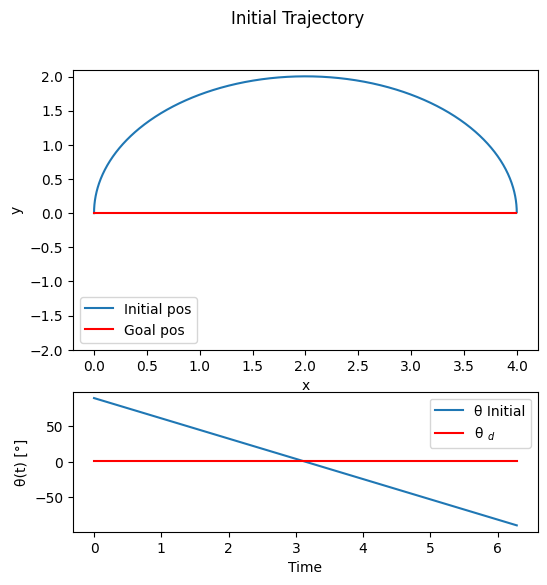

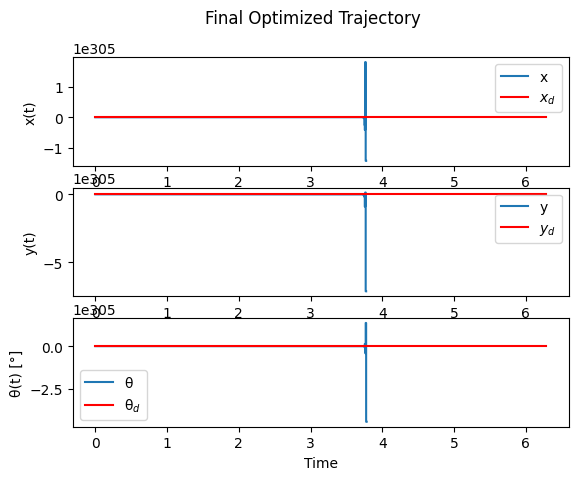

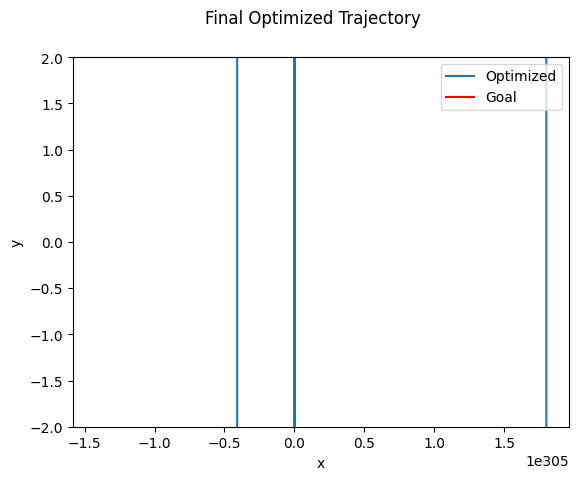

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>

In [204]:
# Plots: Initial Trajectory, Final Optimized Trajectory, Optimized Control Signal
time_discr = np.linspace(0, T, n)

#Plot Initial Trajectory
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[2, 1], figsize=(6, 6))
ax1.plot(x_init[:,0], x_init[:,1], label='Initial pos')
ax1.plot(x_g[:,0], x_g[:,1], color='red', label='Goal pos')
ax2.plot(time_discr, x_init[:,2]*180/np.pi, label="\u03B8 Initial")
ax2.plot(time_discr, x_g[:,2], color='red', label="\u03B8 $_{d}$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_ylim([-2, 2.1])
ax2.set_xlabel("Time")
ax2.set_ylabel("\u03B8(t) [°]")
ax1.legend()
ax2.legend()
fig.suptitle("Initial Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_init_traj.png')

#Plots Final Optimized Trajectory
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.step(time_discr, x_iLQR[:,0], label="x")
ax2.step(time_discr, x_iLQR[:,1], label="y")
ax1.plot(time_discr, x_g[:,0], color='red', label=r"$x_{d}$")
ax2.plot(time_discr, x_g[:,1], color='red', label=r"$y_{d}$")
ax3.step(time_discr, x_iLQR[:,2], label="\u03B8")
ax3.plot(time_discr, x_g[:,2], color='red', label="\u03B8$_{d}$")
ax1.set_xlabel("Time")
ax1.set_ylabel("x(t)")
ax2.set_xlabel("Time")
ax2.set_ylabel("y(t)")
ax3.set_xlabel("Time")
ax3.set_ylabel("\u03B8(t) [°]")
ax1.legend()
ax2.legend()
ax3.legend()
fig2.suptitle("Final Optimized Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_time.png')

fig3, ax = plt.subplots()
ax.step(x_iLQR[:,0], x_iLQR[:,1], label='Optimized')
ax.plot(x_g[:,0], x_g[:,1], color='red', label='Goal')
ax.legend()
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
fig3.suptitle("Final Optimized Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_xy.png')

# Plot Optimized Control Signal
fig4, ax = plt.subplots()
ax.step(time_discr, u_iLQR[:,0], label=r"u$_{1}$")
ax.step(time_discr, u_iLQR[:,1], label=r"$u_{2}$")
ax.legend(loc='upper right')
ax.set_xlabel("Time")
ax.set_ylabel(r"$u(t)$")
fig4.suptitle("Optimized Controls")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_u.png')